In [69]:
library(data.table) 
library(lmtest)
library(sandwich)
library(stargazer)


Please cite as: 

 Hlavac, Marek (2015). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2. http://CRAN.R-project.org/package=stargazer 



# Intent to Treat and Compliers Average Treatment Effects 

So far this week, we've been thinking about a new concept -- the possiblity that we tell people that they have been randomly placed in a treatment condition, but that they don't reliably take that condition. 

To this point, this has come with attendant changes in our notational system: 

- `d` is the *dose* of treatment that subjects receive; 
- `z` is the *treatment group* that the subject was randomly assigned to. 

Before, we had made the simplifying assumption that $z_{i}=1 \rightarrow d_{i}=1$. In this *brave new world* it might not be the case that that this relationship alwasys holds. That is, it might be that we have assigned someone to take the treatment, but they are a *never taker* who *doesn't comply* with that assignment. That is, $z_{i}=1$, but $d_{i}=0$. 

## Consequences of Non Compliance 

What happens to our estimated treatment effect when there is non-compliance? Well, that actually depends "on the arrangement of the data" -- which is just a jargon way to say that the two-group estimate could be **larger** or **smaller** than the true causal effect, depending on the covariacne relationships in the data. 

## Make Data 

Let's make a quick function that will produce data. This time, we are going to write a short function that will let us produce data either *with random non-compliance* or *with systematic non-compliance*. 

In [73]:
make_data <- function(nrows=1000, random_non_compliance=TRUE, treat_size=5) { 
    ## this function will make data for the purposes of learning
    ## about how  random or non-random non-compliance will change
    ## a two-group difference estimate of those who are treated.

    require(data.table, quietly = TRUE)
    
    d <- data.table(id = 1:nrows) 

    d[ , y0 := rnorm(nrows, mean = 10)]
    d[ , tau := rnorm(nrows, mean = treat_size)]
    d[ , y1 := y0 + tau]

    d[ , assigned := sample(0:1, .N, replace=T, prob = c(0.5, 0.5))] # z in the book
    
    d[assigned == 0, treated := 0L] 
    
    if(random_non_compliance) {
        ## random non-compliance
        d[assigned == 1,
          treated := sample(c(1,0), size=.N, replace=TRUE, prob=c(.7, .3))]
    } else {
        ## non-random non-compliance; based on potential outcomes to treatment 
        d[assigned == 1 & y1 > mean(y1),
          treated := sample(1:0, size=.N, replace=TRUE, prob=c(.7, .3))]
        d[assigned == 1 & y1 < mean(y1),
          treated := sample(1:0, size=.N, replace=TRUE, prob=c(.2, .8))]
    }

    d[treated == 1, Y := y1]
    d[treated == 0, Y := y0]

    return(d)

}

## Questions of Understanding 
1. What is happening in the `if` block in this function? Among the people who are assigned to treatment: 
  1. What information does the `treated` variable encode? 
  2. What does the `sample` function do, and what is the `prob` argument to this function? 
2. What is happening in the `else` block in this function? 
  1. What are the filtering statements doing and how are each different? 
  2. If someone's potential outcomes to treatment are higher than average, are they more likely to comply than someone whose potential outcomes to treatment are lower than average? How do you know this? 

In [16]:
d <- make_data(nrows = 1000, random_non_compliance = TRUE)
head(d) 

id,y0,tau,y1,assigned,treated,Y
1,9.224055,7.356996,16.58105,1,0,9.224055
2,9.226536,6.047394,15.27393,1,1,15.273930
3,9.187702,4.780534,13.96824,0,0,9.187702
4,9.812834,2.878594,12.69143,0,0,9.812834
5,7.694449,5.143330,12.83778,1,0,7.694449
6,9.236976,4.163977,13.40095,0,0,9.236976


This data.table `d` has a lot of infomration that we wouldn't have access to in the real world when we run the experiment. In the real world, instead we would only observe: 

In [17]:
obs <- d[ , .(assigned, treated, Y)]

With this data in hand we can calculate all of the causal quantities that we're after. Horray! 

### Estimate the Intent to Treat Effect 

The intent to treat effect is the difference between the group that we assign to receive treatment and the group that we assign to receive control. Note that this isn't necessairily people who took treatment and contorl, in this brave new world people are able to choose whether or not to take the thing they are assigned to. 

How do we calculate the ITT using a difference in means estimator? *Just the same way we always have!* 

In [18]:
itt <- obs[ , .(mean_y = mean(Y)), keyby = .(assigned)][ , diff(mean_y)]
itt

[1] 3.512944

Wait, but didn't we set the treatment effect above to be equal to 5 on average? 

In [19]:
d[ , mean(tau)]

[1] 5.022097

Why then are we generating an intent to treat that is so much smaller than the true treatment effect in the data? 

Among the people that we assigned to take the treatment, what proportion of them actually took it? We can answer this question with a simple subset and average. 

In [20]:
alpha <- d[assigned == 1, mean(treated)]

And so, with both the intent to treat (`itt`) and the compliance rate (`alpha`) calculated we can produce a reliable estiamte of the compliers causal effect. 

In [21]:
itt / alpha

[1] 5.043437

It isn't *exactly* the causal effect that we created when we produce `tau` in the `make_data` function, but the differences are only a product of the limited sample size that we are working with. If, rather than 1,000 observations, we had 1,000,000 we would be very, *very* close. 

In [26]:
d_6     <- make_data(nrows = 1e6)
itt_6   <- d_6[ , .(mean_y = mean(Y)), keyby = .(assigned)][ , diff(mean_y)]
alpha_6 <- d_6[assigned==1, mean(treated)]
cace_6  <- itt_6/alpha_6
cace_6

[1] 4.999831

# Estimate the same quantities with linear models 

As with every two-group estimator in the course, we can also estimate this quantity using linear models. Because the design work produces solid, causal contrasts, the estimators are always easy! 

But, with a linear model, we could possibly include additional covariates that might improve the efficiency of the estimates (thereby producing more power). 

To estiamte the CACE using linear models, we can produce the same sets of estimates as before, just with models. 

In [27]:
model_itt <- d[ , lm(Y ~ assigned)]
model_compliance <- d[ , lm(treated ~ assigned)]

Each of these models will have coefficients and standard error estiamtes. For example, consider the summary of the `model_itt`. 

In [30]:
coeftest(model_itt)


t test of coefficients:

            Estimate Std. Error t value  Pr(>|t|)    
(Intercept) 9.980116   0.088207 113.144 < 2.2e-16 ***
assigned    3.512944   0.125882  27.907 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The `(Intercept)` estimates the average in the control group (which we set to be 10 in the `make_data` function call), and the `assigned` coefficient estimates the marginal change between the treatment and control groups. It is **exactly** what we calculated in the difference in means! :+1:

The same holds for the compliance rate model. 

In [31]:
coeftest(model_compliance)


t test of coefficients:

               Estimate  Std. Error t value Pr(>|t|)    
(Intercept) -1.6852e-16  1.4294e-02   0.000        1    
assigned     6.9654e-01  2.0399e-02  34.146   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


This value is exactly the same as the difference in means that we calculated in the difference in means calculation for `alpha`. 

We could use these coefficients to indirectly compute the CACE in the following ways: 

In [33]:
(coef(model_itt) / coef(model_compliance))[2]

assigned 
5.043437

In [34]:
coef(model_itt)[2] / coef(model_compliance)[2]

assigned 
5.043437

Note that this does not have  clear estimate of the uncertainty associated with it. That is a drag... 

In order to estimate with a reliable standard error, we can turn to 
two stage least squares (2SLS), which is a particular, feasible estimate of an instrumental variables regression. 

2SLS has the benefit of:
  
  1. Doing _exactly_ the same thing that the CACE = ITT / ITT_{d}; but,
  2. Doing it in a way that has known standard errors that are quickly and easily computable. 

# Two Stage Least Squares 

2SLS are, rather creatively named because there are **two stages of least squares estimates**. Hey, nobody ever accused economists for being particularily creative... 

Here's how this process works: 

## In the first stage: 
1. Estimate the proportion of people who are receive treatment as a function of being assigned to treatment. 
2. Then make predictions about the **probability** that someone is treated. These predictions, because of an orthagonal projection feature of OLS regression, are: 
  - Uncorrelated with anything in the world; 
  - With the single exception of the treatment assignment (which itself is uncorrelated with anything in the world.

In [41]:
## Here we're fitting the model, and then making
## predictions from that fitted model. 
## 
## Note that I'm rounding the predictions, just so they 
## print more nicely. There's no math reason for doing this. 

model_first <- d[ , lm(treated ~ assigned)]
d[ , predicted_treatment := round(predict(model_first), 3)]

head(d)

id,y0,tau,y1,assigned,treated,Y,predicted_treatment
1,9.224055,7.356996,16.58105,1,0,9.224055,0.697
2,9.226536,6.047394,15.27393,1,1,15.273930,0.697
3,9.187702,4.780534,13.96824,0,0,9.187702,0.000
4,9.812834,2.878594,12.69143,0,0,9.812834,0.000
5,7.694449,5.143330,12.83778,1,0,7.694449,0.697
6,9.236976,4.163977,13.40095,0,0,9.236976,0.000


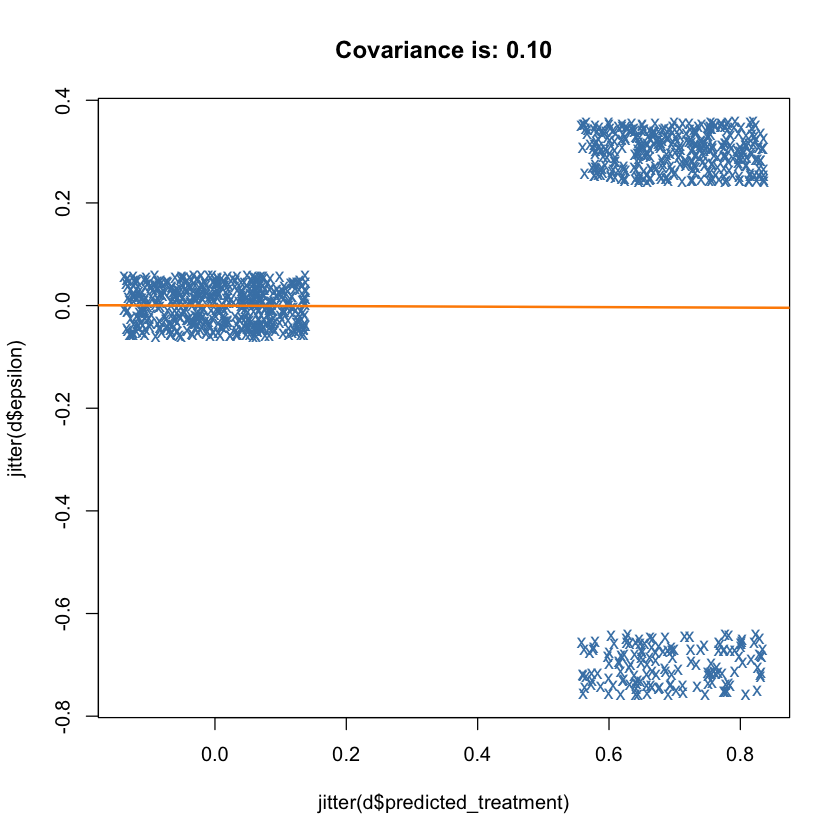

In [56]:
d[ , epsilon := round(resid(model_first), 2)]
model_residuals <- d[ , lm(epsilon ~ predicted_treatment)]
plot(jitter(d$predicted_treatment), jitter(d$epsilon), 
     main = sprintf("Covariance is: %.2f", cov(d$treated, d$epsilon)), 
     pch = 'x', col = 'steelblue')
abline(model_residuals, col = 'darkorange', lwd = 2)

## In the second stage

In the second stage of OLS regressions, use these `predicted_treatment` variables that you have just constructed as the **exogeneous, random, treatment** indicator in a regression on the outcome you're interested in, Y. 

In [59]:
second <- d[ , lm(Y ~ predicted_treatment)]
coeftest(second, vcovHC(second, type = 'HC3'))


t test of coefficients:

                    Estimate Std. Error t value  Pr(>|t|)    
(Intercept)         9.980116   0.044962 221.967 < 2.2e-16 ***
predicted_treatment 5.040092   0.183229  27.507 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Shoot dang! That's got an estimate of the CACE, and also a standard error surrounding it that is informative of our uncertainty in that parameter estimte. That means that we can make an inference about this effect. :tada: 

# Using built packages 

As with most stats in R, there is a pre-built version of this 2SLS. Also, as with most stats in R, it isn't hard to do this by hand, yourself. 

However, the 2SLS that is built is really good, and this is a pretty common task. So, we think it is worth being familiar with the syntax. 

In [64]:
library(AER)

In the model below, the outcome variable is in the typical spot, to the left of the tilde. However there are more model terms in the formula. 
- To the right of the pipe -- `|` -- is the exogeneous thing that we actually *got to assign* and is random. 
- To the left of the pipe are the things that are not exogeneous, or at least not fully. 

In [65]:
model_iv <- d[ , ivreg(Y ~ treated | assigned)]

In [66]:
summary(model_iv, diagnostics = TRUE)


Call:
ivreg(formula = Y ~ treated | assigned)

Residuals:
     Min       1Q   Median       3Q      Max 
-5.79510 -0.71198 -0.01655  0.72737  3.53606 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.98012    0.05081  196.43   <2e-16 ***
treated      5.04344    0.10410   48.45   <2e-16 ***

Diagnostic tests:
                 df1 df2 statistic p-value    
Weak instruments   1 998      1166  <2e-16 ***
Wu-Hausman         1 997         0   0.995    
Sargan             0  NA        NA      NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.146 on 998 degrees of freedom
Multiple R-Squared: 0.8136,	Adjusted R-squared: 0.8134 
Wald test:  2347 on 1 and 998 DF,  p-value: < 2.2e-16 


- **Weak instruments**: This is an F-test on the instruments in the first stage. The null hypothesis is essentially that we have weak instruments, so a rejection means our instruments are not weak, which is good.
- **Wu-Hausman**: This tests the consistency of the OLS estimates under the assumption that the IV is consistent. When we reject, it means OLS is not consistent, suggesting endogeneity is present. If we accept the null, it essentially means that the OLS and IV estimates are similar, and endogeneity may not have been a big problem. (Note that, as ever, failing to reject a null hypothesis is little comfort...) 

In the data that we're presently dealing with, it **is the case** that the non-compliance was totally at random, right? So, the failure of the Wu-Hausman test to reject the null actually makes pretty good sense, there isn't a difference in what we estimate under OLS and 2SLS. 

In [70]:
model_lucky <- d[ , lm(Y ~ treated)]
stargazer(model_iv, model_lucky, type = 'text')


                                         Dependent variable:          
                               ---------------------------------------
                                                  Y                   
                               instrumental            OLS            
                                 variable                             
                                   (1)                 (2)            
----------------------------------------------------------------------
treated                          5.043***            5.044***         
                                 (0.104)             (0.076)          
                                                                      
Constant                         9.980***            9.980***         
                                 (0.051)             (0.045)          
                                                                      
----------------------------------------------------------------------
Obser

This isn't generally the case! 

# Make data with compliance related to potential outcomes 

Here, we return to the `make_data` call, but now set the flag so that non-compliance is related in a meaningful way to individual's "taste" for being in treatment. 

That is, we're going to be in the `else` block of the `make_data` function. 

        ## non-random non-compliance; based on potential outcomes to treatment 
        d[assigned == 1 & y1 > mean(y1),
          treated := sample(1:0, size=.N, replace=TRUE, prob=c(.7, .3))]
        d[assigned == 1 & y1 < mean(y1),
          treated := sample(1:0, size=.N, replace=TRUE, prob=c(.2, .8))]

In this else block, the people who have relatively high potential outcomes to treatment are going to comply with treatment, while those with relatively low potential outcomes to treatment are not going to comply with treatment. 

In [74]:
d <- make_data(nrows = 1000, random_non_compliance = FALSE, treat_size = 5)

What do we estimate as an ITT under this data? 

In [76]:
itt <- d[ , lm(Y ~ assigned)]
coef(itt)[2]

assigned 
2.482558

An intent to treat effect of about 2.5. 

What is the compliance rate? 

In [77]:
alpha <- d[ , lm(treated ~ assigned)]
coef(alpha)[2]

assigned 
0.4613861

Which provides a CACE of: 

In [78]:
coef(itt)[2] / coef(alpha)[2]

assigned 
5.380651

Can you produce this using a 2SLS? 

In [79]:
## estimate the first stage 
first <- ''
## predict the changes in treatment 

## estimate the second stage 
second <- ''



Does this comport with the estimates from the `AER::ivreg` call? 

In [80]:
model_iv <- d[ , ivreg(Y ~ treated | assigned)]
summary(model_iv, diagnostics = TRUE)


Call:
ivreg(formula = Y ~ treated | assigned)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.85012 -0.68497  0.03352  0.67656  4.84102 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.96394    0.04985  199.90   <2e-16 ***
treated      5.38065    0.15202   35.39   <2e-16 ***

Diagnostic tests:
                 df1 df2 statistic  p-value    
Weak instruments   1 998    423.18  < 2e-16 ***
Wu-Hausman         1 997     14.15 0.000179 ***
Sargan             0  NA        NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.109 on 998 degrees of freedom
Multiple R-Squared: 0.8319,	Adjusted R-squared: 0.8317 
Wald test:  1253 on 1 and 998 DF,  p-value: < 2.2e-16 


1. We've produced the same estimate of the CACE as we did earlier using the hand-built two-stage estimator. 
2. We have rejected the Weak Instruments test (good!) 
3. We have rejected the Wu-Hausman test (this was necessary because the OLS and 2SLS estimates would have told us different causal estimates). 